In [13]:
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astroML.plotting.mcmc import convert_to_stdev
import celerite
from celerite import terms
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
import os
import scipy

In [15]:

# read in the files  with logL evaluated on a grid
# and calculate the expectation value .... 

for simulation in ['SDSS','OGLE'] :
    if simulation is 'SDSS':
        N = 60
    if simulation is 'OGLE':
        N = 445
    resDir  = '../data_products/Simulated_DRW_Kozlowski/'+\
             simulation+'/190207_results_celerite/'#'/180619_tuesday_work/'

    files = os.listdir(resDir)
    print('For ', simulation, ', using ', len(files), ' files')
    
    # initialize storage dict 
    loglike_results = {'lc_name': np.zeros_like(files),
                      'sigma_EXP':np.zeros(len(files), dtype=float),
                      'tau_EXP':np.zeros(len(files), dtype=float),
                     'sigma_MAP':np.zeros(len(files), dtype=float),
                      'tau_MAP':np.zeros(len(files), dtype=float),
                       'rho_in':np.zeros(len(files), dtype=float),
                       'tau_in':np.zeros(len(files), dtype=float),
                      }
    
    rho_min, rho_max,  n_rho = 0.001, 15, 100
    rho_grid = np.logspace(np.log10(rho_min), np.log10(rho_max), n_rho)

    for prior in ['Jeff1', 'Jeff2']:
        for k in range(len(files)) : 
            fname = files[k]
            loglike_results['lc_name'][k] = fname[:-9] + '.dat'
            results = np.load(resDir+fname).item()

            # recover rho and tau : input parameters 
            loglike_results['rho_in'][k] = results[prior]['rho_in']
            loglike_results['tau_in'][k] = results[prior]['tau_in']

            # we are storing log Posterior ...
            logP = results[prior]['logPosterior']

            # read the MAP results 
            loglike_results['sigma_MAP'][k] = results[prior]['sigma_MAP']
            loglike_results['tau_MAP'][k] = results[prior]['tau_MAP']

            # we also store the actual grid....
            sigma_grid = results[prior]['sigma_grid']
            tau_grid   = results[prior]['tau_grid']

            # read the expectation value ... 
            # computed using mod.find_expectation_value()
            loglike_results['sigma_EXP'][k] = results[prior]['sigma_EXP']
            loglike_results['tau_EXP'][k]   = results[prior]['tau_EXP']

        # store regardless of prior...
        loglike = Table(loglike_results)
        fname  = 'loglike_'+prior+'_'+str(int(N))+'_'+simulation+'.txt'
        print('Saved as ', fname)
        loglike.write(fname, format='ascii',overwrite=True)

    

Using  5012  files
Done
Saved as  loglike_Jeff1_60_SDSS.txt
Done
Saved as  loglike_Jeff2_60_SDSS.txt
Using  10000  files
Done
Saved as  loglike_Jeff1_445_OGLE.txt
Done
Saved as  loglike_Jeff2_445_OGLE.txt


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2906: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Saved as  SDSS_Jeff2_MAP.png
Saved as  SDSS_Jeff2_expectation.png


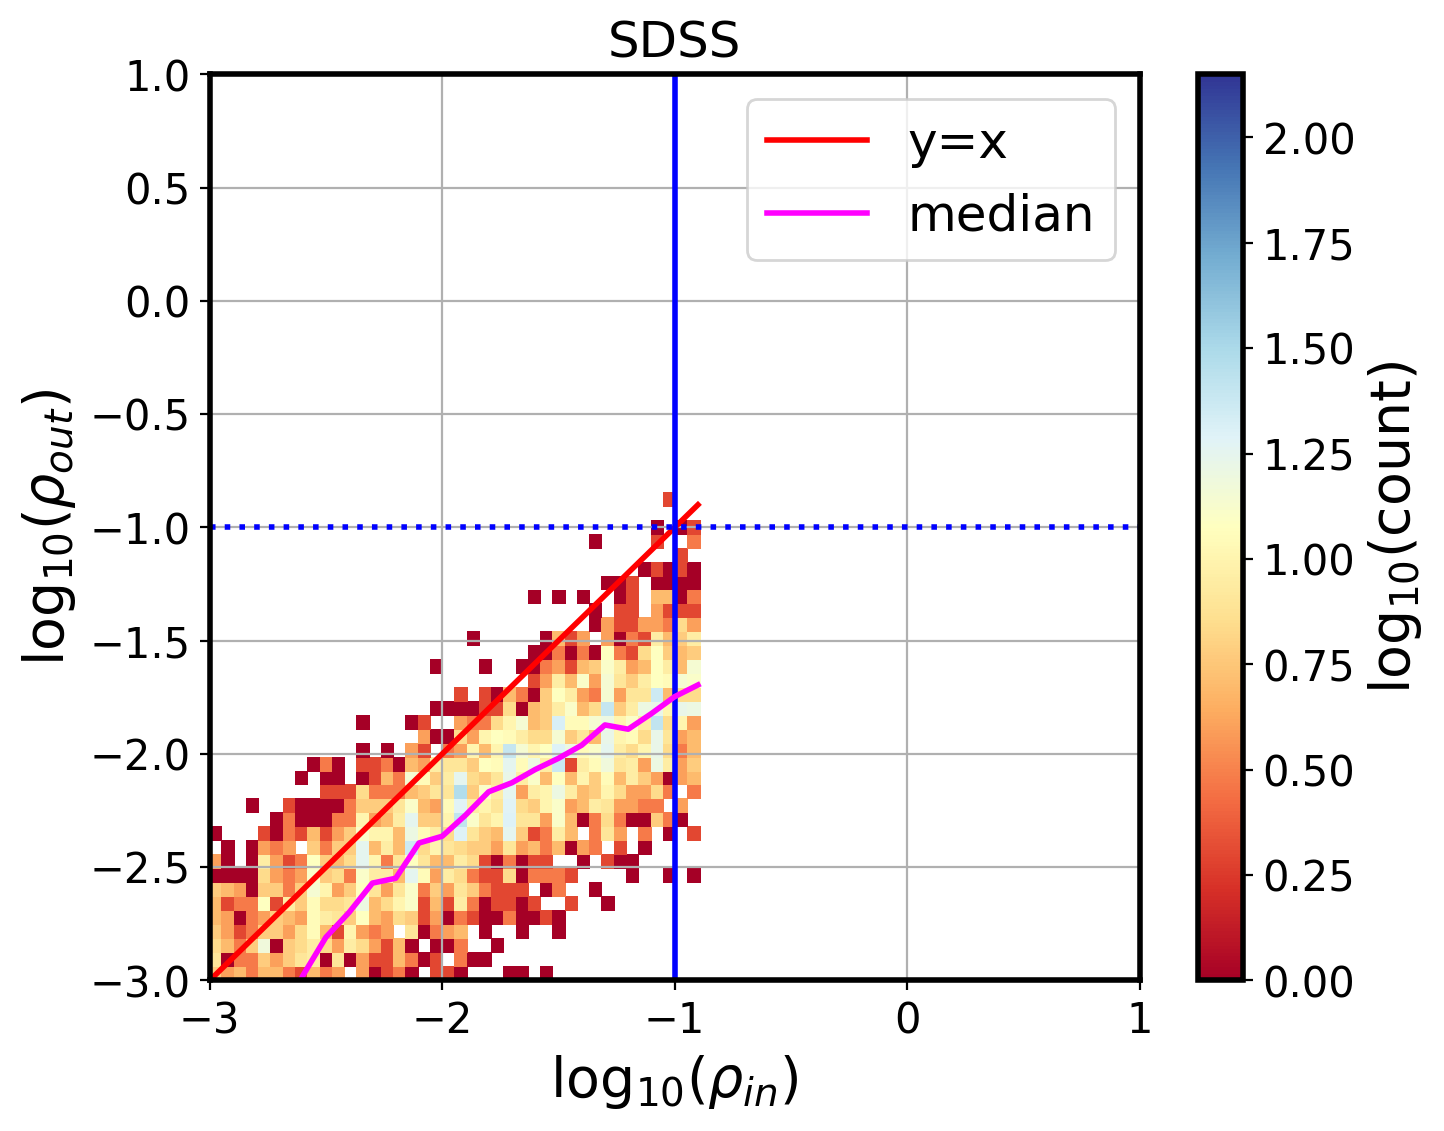

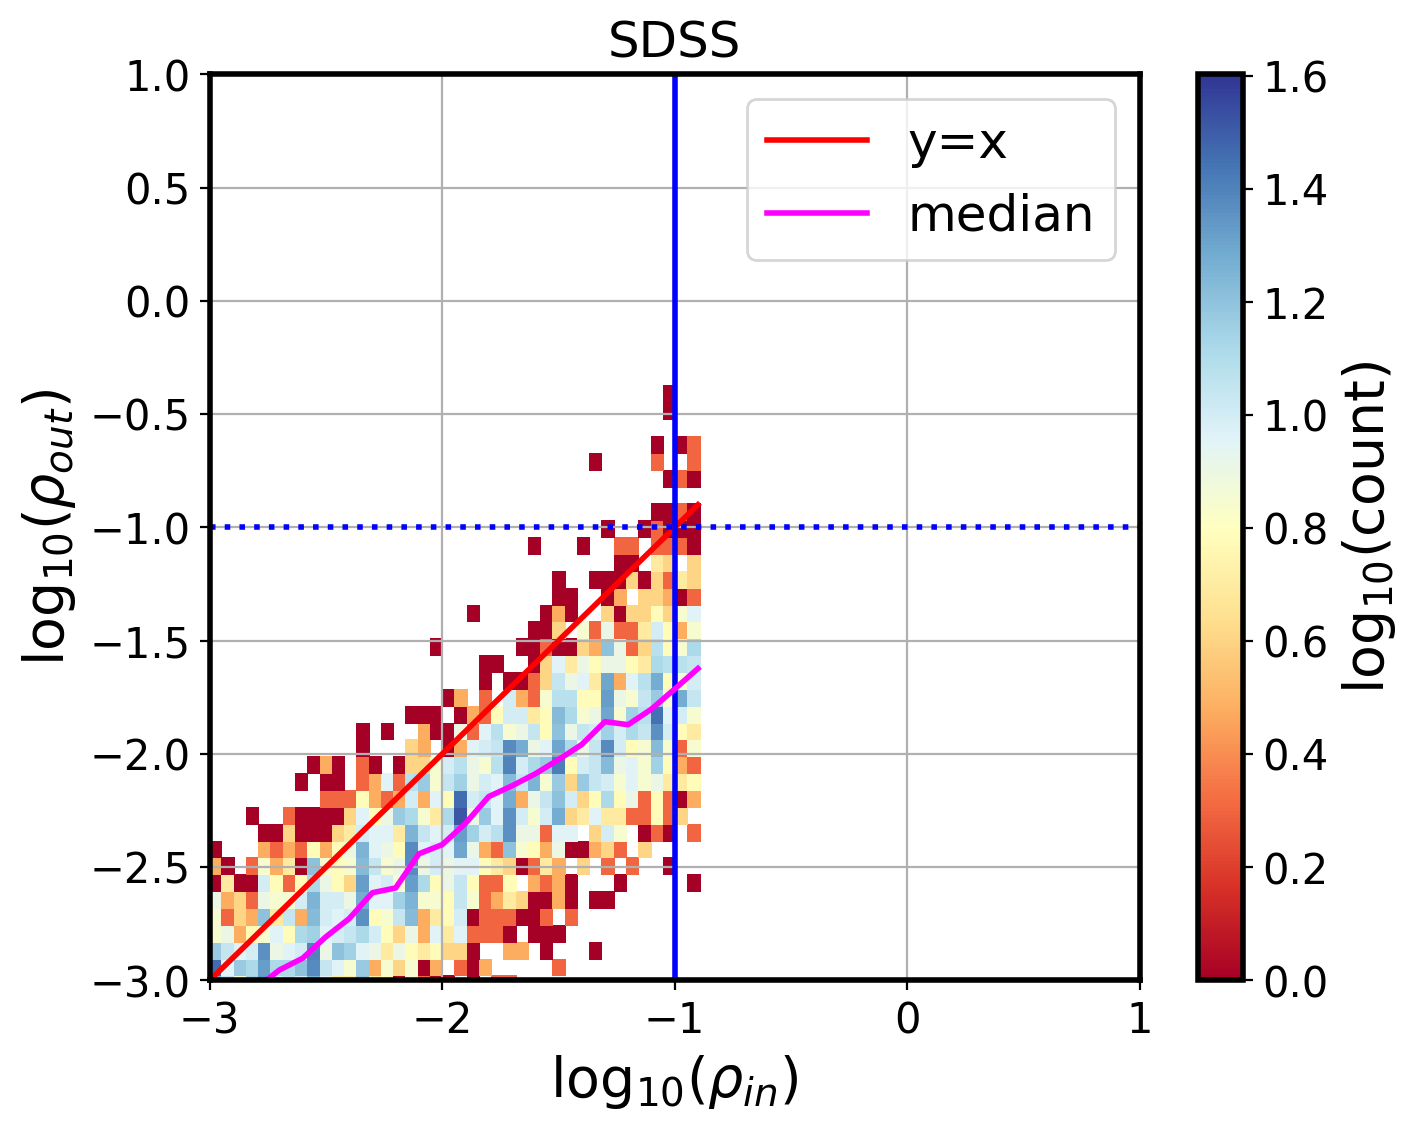

In [16]:
%matplotlib inline
from scipy.stats import binned_statistic_2d

prior='Jeff2'
simulation= 'SDSS'#'SDSS'#'OGLE'# 'SDSS'

if simulation is 'SDSS':
    N = 60
if simulation is 'OGLE':
    N = 445 

fname = 'loglike_'+prior+'_'+str(int(N))+'_'+simulation+'.txt'
loglike = Table.read(fname, format='ascii')

%config InlineBackend.figure_format='retina'
#fig = plt.figure(figsize=(10, 5), dpi=100)

t_exp = 8 * 365.0 # days 
rho_in = loglike['rho_in']
for label in ['MAP', 'expectation']:
    if label is 'MAP':
        rho_out  = loglike['tau_MAP']/t_exp #* np.power(10,0.16)
    elif label is 'expectation':
        rho_out  = loglike['tau_EXP'] / t_exp

    fig,ax = plt.subplots(1,1,figsize=(7.5,6), dpi=100)
    x = np.log10(rho_in)
    y = np.log10(rho_out)

    stats = binned_statistic_2d(x, y, x, statistic='count', bins=40)
    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
    image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                             cmap=plt.cm.get_cmap('RdYlBu'))
    # labels...
    ax.set_xlabel(r'$\log_{10}(\rho_{in})$')
    ax.set_ylabel(r'$\log_{10}(\rho_{out})$')

    plt.colorbar(image, label=r'$\log_{10}{(\mathrm{count})}$')
    # lines to guide the eye ...
    ax.grid()
    xlim = ax.get_xlim()
    x_line = np.arange(xlim[0], xlim[1],0.01)
    ax.plot(x_line,x_line, ls='-', lw=2, color='red', label='y=x')
    ax.axhline(-1, ls=':', lw=2, c='blue')
    ax.axvline(-1, ls='-', lw=2, c='blue')

    # calculate the median of log(rho_out)
    # Median of the log(y) is not the log(median(y)) .... 
    min_x, max_x , step_size = xlim[0],xlim[1], 0.1
    mean_x = np.arange(min_x, max_x+step_size , step_size)
    dx = 0.5 * step_size 
    median_y = np.zeros(len(mean_x))

    for j in range(len(median_y)):
        # take points that are within desired x_data limits for each bin
        # i.e. marginalize along y ( stack vertically)
        mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
        median_y[j] = np.median(y[mask])

    ax.plot(mean_x[:-1], median_y[:-1], c = 'magenta',lw=2, label='median')#, s=50 , edgecolor='black')
    ax.legend(fontsize=18)
    ax.set_title(simulation)#+', '+label)
    ax.set_ylim(-3,1)
    ax.set_xlim(-3,1)
    figname = simulation+'_'+prior+'_'+label+'.png'
    plt.savefig(figname, bbox_inches='tight')
    print('Saved as ', figname)